# Lab Deep Learning/ Recurrent Neural Networks/ in keras

## Training language model for generating sequences (One-to-Many)

**Author: geoffroy.peeters@telecom-paris.fr**

**Version**: 2023/09/19 (changed to tensorfow.keras, changed figures, code to function)

For any remark or suggestion, please feel free to contact me.


## Objective:

- We will train a network to learn a language model and then use it to generate new sequences.

- Instead of training the language model on text-documents (as it is the case in most examples) we will train it to learn the language of the music of [Johann_Sebastian_Bach](https://en.wikipedia.org/wiki/Johann_Sebastian_Bach).
For this, we will learn how J. S. Bach's "Cello suite" have been composed.
Here is an example of a "Cello suite" [Link](https://www.youtube.com/watch?v=mGQLXRTl3Z0).

- Rather than analyzing the audio signal, we use a symbolic representation of the "Cello suite" through their [MIDI files](https://en.wikipedia.org/wiki/MIDI#MIDI_files).
  - A MIDI file encodes in a file, the set of musical notes, their duration, and intensity which have to be played by each instrument to "render" a musical piece. The "rendering" is usually operated by a MIDI synthesizer (such as VLC, QuickTime) or a real performer (a musician reading a score).

- We will first train a language model on the whole set of MIDI files of the "Cello suites".
- We will then sample this language model to create a new MIDI file which will be a brand new "Cello suite" composed by the computer.

### Questions:

In the bottom part of this lab, you will have to answer a set of questions. Answers to those only necessitates a couple of sentences.

## Import packages

In [1]:
! pip install pretty_midi

import os
import pretty_midi
from scipy.io import wavfile
import IPython

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import numpy as np
import glob

student = True

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 48.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.7 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=663355971448a4a2ea54464f00564a24fdd3cd92808faa67d8d6f073c47c57ae
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


# Get the data

In [2]:
# n_x --- the number of notes (here we consider the problem as a multi-class with n_x classes)
n_x = 79
# max_midi_T_x --- the maximum number of notes we read in each midi_file
max_midi_T_x = 1000
# model_T_x --- the length of the sequences considered for the RNN model
#model_T_x = 200
model_T_x = 100
# model_n_a --- the number of neurons of each layer of the network
#model_n_a = 256
model_n_a = 32

## Collect data to create the language model

We download the 36 MIDI files corresponding to the 36 "Cello suites" composed by J. S. Bach.

In [3]:
DIR = './'
import urllib.request
midi_file_l = ['cs1-2all.mid', 'cs5-1pre.mid', 'cs4-1pre.mid', 'cs3-5bou.mid', 'cs1-4sar.mid', 'cs2-5men.mid', 'cs3-3cou.mid', 'cs2-3cou.mid', 'cs1-6gig.mid', 'cs6-4sar.mid', 'cs4-5bou.mid', 'cs4-3cou.mid', 'cs5-3cou.mid', 'cs6-5gav.mid', 'cs6-6gig.mid', 'cs6-2all.mid', 'cs2-1pre.mid', 'cs3-1pre.mid', 'cs3-6gig.mid', 'cs2-6gig.mid', 'cs2-4sar.mid', 'cs3-4sar.mid', 'cs1-5men.mid', 'cs1-3cou.mid', 'cs6-1pre.mid', 'cs2-2all.mid', 'cs3-2all.mid', 'cs1-1pre.mid', 'cs5-2all.mid', 'cs4-2all.mid', 'cs5-5gav.mid', 'cs4-6gig.mid', 'cs5-6gig.mid', 'cs5-4sar.mid', 'cs4-4sar.mid', 'cs6-3cou.mid']
for midi_file in midi_file_l:
  #if os.path.isfile(DIR + midi_file) is None:
  urllib.request.urlretrieve ("http://www.jsbach.net/midi/" + midi_file, DIR + midi_file)

midi_file_l = glob.glob(DIR + 'cs*.mid')
print(midi_file_l)

['./cs6-6gig.mid', './cs6-1pre.mid', './cs1-6gig.mid', './cs2-2all.mid', './cs5-1pre.mid', './cs4-3cou.mid', './cs2-3cou.mid', './cs6-4sar.mid', './cs6-5gav.mid', './cs1-2all.mid', './cs4-4sar.mid', './cs4-1pre.mid', './cs3-3cou.mid', './cs1-1pre.mid', './cs5-4sar.mid', './cs5-5gav.mid', './cs5-3cou.mid', './cs2-1pre.mid', './cs6-2all.mid', './cs5-2all.mid', './cs3-6gig.mid', './cs1-3cou.mid', './cs3-1pre.mid', './cs1-4sar.mid', './cs2-6gig.mid', './cs3-5bou.mid', './cs3-4sar.mid', './cs2-4sar.mid', './cs4-2all.mid', './cs2-5men.mid', './cs1-5men.mid', './cs3-2all.mid', './cs4-6gig.mid', './cs6-3cou.mid', './cs5-6gig.mid', './cs4-5bou.mid']


## Read and convert all MIDI files

We illustrate here the content of a MIDI file. Each file contains a list of notes to be played over time. Each note is characterized by
- its `pitch` (in MIDI note number, la3=A4=69)
- its `start` time (when to start playing the note)
- its `stop` time (when to stop playing the note)
- its `duration` (which is computed as stop-start)

In [4]:
# --- Read a single MIDI file
midi_data = pretty_midi.PrettyMIDI(midi_file_l[0])
# --- Display the note pitch, start, end and duration
for note in midi_data.instruments[0].notes[:20]:
    print('pitch: %d, start: %f, end: %f, duration: %f' % (note.pitch, note.start, note.end, note.end-note.start))

pitch: 69, start: 0.600000, end: 0.850000, duration: 0.250000
pitch: 62, start: 0.850000, end: 1.600000, duration: 0.750000
pitch: 64, start: 1.600000, end: 1.850000, duration: 0.250000
pitch: 66, start: 1.850000, end: 2.100000, duration: 0.250000
pitch: 67, start: 2.100000, end: 2.350000, duration: 0.250000
pitch: 66, start: 2.350000, end: 2.600000, duration: 0.250000
pitch: 62, start: 2.600000, end: 2.850000, duration: 0.250000
pitch: 69, start: 2.850000, end: 3.100000, duration: 0.250000
pitch: 69, start: 3.100000, end: 3.225000, duration: 0.125000
pitch: 67, start: 3.225000, end: 3.350000, duration: 0.125000
pitch: 66, start: 3.350000, end: 3.475000, duration: 0.125000
pitch: 67, start: 3.475000, end: 3.600000, duration: 0.125000
pitch: 69, start: 3.600000, end: 3.850000, duration: 0.250000
pitch: 62, start: 3.850000, end: 4.100000, duration: 0.250000
pitch: 57, start: 4.100000, end: 4.350000, duration: 0.250000
pitch: 62, start: 4.350000, end: 4.600000, duration: 0.250000
pitch: 6

We read each MIDI file and for each only retains the `pitch` (we name it `note`) information.
We convert the list of `note`  to a one-hot-encoding matrix X_ohe of dimensions `(midi_T_x, n_x)` where `n_x` is the number of possible musical notes.
The length of the sequences `midi_T_x` can vary from one sequence to the other.



In [5]:
def F_convert_midi_2_list(midi_file_l, max_midi_T_x):
    """
    read the notes within all midi files
    truncate the length if > max_midi_T_x

    Parameters
    ----------
    midi_file_l:
        list of MIDI files
    max_midi_T_x:
        the maximum number of notes we read in a given midi_file

    Returns
    -------
    X_list:
        a list of np.array X_ohe of size (midi_T_x, n_x) which contains the one-hot-encoding representation of notes over time
    """
    X_list = []

    for midi_file in midi_file_l:
        # --- read the MIDI file
        midi_data = pretty_midi.PrettyMIDI(midi_file)
        note_l = [note.pitch for note in midi_data.instruments[0].notes]
        midi_T_x = len(note_l) if len(note_l) < max_midi_T_x else max_midi_T_x
        # --- convert to one-hot-encoding
        if student:
            # --- START CODE HERE (01)
            X_ohe = np.zeros((midi_T_x, n_x))
            for t, note in enumerate(note_l[:midi_T_x]):
                X_ohe[t, note-1] = 1
            # --- END CODE HERE

        # --- add X_ohe to the list X_list
        X_list.append(X_ohe)

    return X_list

In [6]:
X_list = F_convert_midi_2_list(midi_file_l, max_midi_T_x)
print(len(X_list))
print(X_list[0].shape)
print(X_list[1].shape)
print(X_list[2].shape)

36
(1000, 79)
(1000, 79)
(420, 79)


## Display the set of notes over time for a specific track

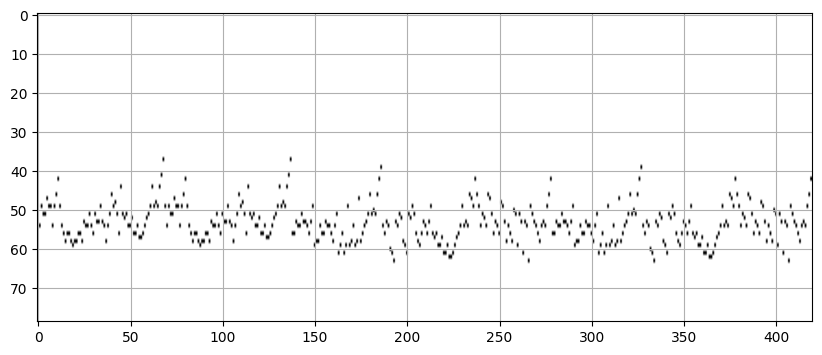

In [7]:
plt.figure(figsize=(10, 4))
plt.imshow(X_list[2].T, aspect='auto')
plt.set_cmap('gray_r')
plt.grid(True)

## Data conversion for the training of language model

We want to train a language model, i.e. a model thats predict a note given past notes: $p(x^{<\tau>} | x^{<1>}, x^{<2>}, ... x^{<\tau-1>})$.

A simple way to do this is to create (for each MIDI sequence and for each possible starting note `t` within this MIDI sequence) two sequences:
- an input sequence $x$:
  - which contains a sub-sequence of length `model_T_x`;  this sub-sequence range from `t` to `t+model_T_x-1`
- an output sequence $y$ :
  - which contains the same sub-sequence but delayed by one time step: ranging from `t+1` to `t+model_T_x`

<img src="https://perso.telecom-paristech.fr/gpeeters/doc/Lab_DL_RNN_03.png">



In [8]:
def F_convert_list_2_data(X_list, model_T_x, sequence_step=1):
    """
    convert X_list to input X_train and output Y_train training data

    Parameters
    ----------
    X_list:
        a list of np.array X_ohe of size (midi_T_x, n_x) which contains the one-hot-encoding representation of notes over time

    Returns
    -------
    X_train:
        the set of all m input sequences; np.array of shape (m, model_T_x, n_x)
    Y_train:
        the set of all m output sequences; np.array of shape (m, model_T_x, n_x)

            note:   m is the total number of training items,
                    it is be larger than the number of MIDI files since we use several starting time t in each MIDI file
    """

    if student:
        # --- START CODE HERE (02)
        X_train_list = []
        Y_train_list = []
        for X_ohe in X_list:
            midi_T_x = X_ohe.shape[0]
            for t in range(0, midi_T_x-model_T_x, sequence_step):
                X_train_list.append(X_ohe[t:t+model_T_x, :])
                Y_train_list.append(X_ohe[t+1:t+model_T_x+1, :])
        # --- END CODE HERE

    X_train = np.asarray(X_train_list)
    Y_train = np.asarray(Y_train_list)

    return X_train, Y_train

X_train.shape: (20901, 100, 79)
Y_train.shape: (20901, 100, 79)


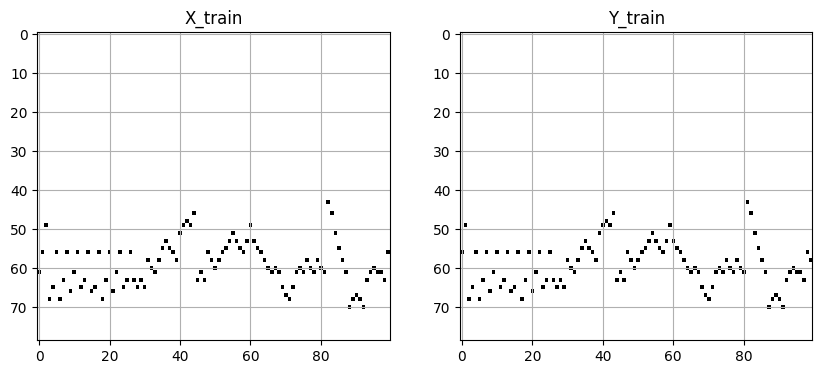

In [9]:
X_train, Y_train = F_convert_list_2_data(X_list, model_T_x)
# --- X_train is of shape (m, model_T_x, n_x)
print("X_train.shape:", X_train.shape)
# --- Y_train is of shape (m, model_T_x, n_x)
print("Y_train.shape:", Y_train.shape)


plt.figure(figsize=(10, 4))
plt.subplot(1,2,1); plt.imshow(X_train[20,:,:].T, aspect='auto'); plt.grid(True); plt.title('X_train')
plt.subplot(1,2,2); plt.imshow(Y_train[20,:,:].T, aspect='auto'); plt.grid(True); plt.title('Y_train')
plt.set_cmap('gray_r')

# Training the language model

To learn the language model we will train an RNN with input `X_train` and output `Y_train`.  
For each example, we give to the network a sequence of notes from `t` to `t+model_T_x-1`  and ask the network to predict the following note of each sequence `t+1` to `t+model_T_x`.
We already created those in `X_train` and `Y_train`.

The network architecture is the following:
- (1a) a layer of `LSTM` with `model_n_a` units
- (1b) a layer of DropOut with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- (2a) a layer of `LSTM` with `model_n_a` units
- (2b) a layer of DropOut with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- (3) a layer of `LSTM` with `model_n_a` units
- (4a) a layer of `Dense` with `model_n_a` units with a `tanh` activation
- (4b) a layer of DropOut with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- (5) a layer of `Dense` with a `softmax` activation which predict the probability of each of the $n_x$ notes as output

## Returning the hidden states at each time of an LSTM cell

By default `LSTM` in keras only outputs the hidden states for the last time step. If we want `LSTM` to output the hidden states for each time steps $t$, we need to use the option `return_sequences=True`.

Note that since we stack one LSTM layer on top of another LSTM layer (deep-RNN), we therefore need to tell the bottom `LSTM` to output its hidden states at each time step $t$.



In [10]:
# --- Create the model
K.clear_session()

if student:
    # --- START CODE HERE (03)
    model = Sequential(
        [
            Input(shape=(model_T_x, n_x)),
            LSTM(model_n_a, return_sequences=True),
            Dropout(0.3),
            LSTM(model_n_a, return_sequences=True),
            Dropout(0.3),
            LSTM(model_n_a, return_sequences=True),
            Dense(model_n_a, activation="tanh"),
            Dropout(0.3),
            Dense(n_x, activation="softmax"),
        ],
        name='language_model'
    )
    # --- END CODE HERE

print(model.summary())

Model: "language_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 32)             │          14,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 32)             │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100, 32)             │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100, 32)             │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100, 79)             │           2,607 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,639 (135.31 KB)

 Trainable params: 34,639 (135.31 KB)

 Non-trainable params: 0 (0.00 B)

None


We now compile the network (`model.compile`) specifying the loss to be optimized (we deal here with a multi-class problem), how to minimize the loss (here we will use `adam` optimizer) and indicate what we want to display during training (here we also ask to display the `accuracy`).

As in `scikit-learn` we then fit the model (`model.fit`), i.e. we train its parameters, by providing the input and the ground-truth output; we also specifify the number of `epochs`to use (one `epoch` correspond to having see the whole training-set, hence it corresponds to several mini-batches, hence to several optimization steps) and the `batch_size`.

We will also use `early-stopping` to avoid over-fitting. `early-stopping` stops the training when the loss on the validation-set stops decreasing. For this we need to create a validation set (we do this by splitting the training-set in two, `validation_split`). We then define a `callback` (something that keras needs to monitor during training, here we monitor the loss on validation-set, `monitor='val_loss`).
`patience=3` indicates that we wait for 3 epochs after the criteria is not valid.

In [11]:
# --- Compile and fit the model
callback = EarlyStopping(monitor='val_loss', patience=3)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=100, batch_size=16, validation_split=0.1, shuffle=True, callbacks=[callback])

Epoch 1/100
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.0850 - loss: 3.3349 - val_accuracy: 0.1743 - val_loss: 2.5876
Epoch 2/100
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.1639 - loss: 2.6398 - val_accuracy: 0.2085 - val_loss: 2.4991
Epoch 3/100
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.1947 - loss: 2.5420 - val_accuracy: 0.2265 - val_loss: 2.4690
Epoch 4/100
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.2369 - loss: 2.4382 - val_accuracy: 0.2543 - val_loss: 2.4600
Epoch 5/100
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.2732 - loss: 2.3347 - val_accuracy: 0.2580 - val_loss: 2.4794
Epoch 6/100
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.3008 - loss: 2.2555 - val_accuracy: 0.2632 - val_loss: 2.4822
Epoch 7/100
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.3210 - loss: 2.1934 - val_accuracy: 0.2633 - val_loss: 2.5199


# Generating a new sequence by sampling the language model

To generate a new sequence from the language model,

- we first randomly choose a starting note among the `n_x` possible ones. For this you can use `
np.random.multinomial` and either
    - assume an uniform distribution
    - compute a prior note distribution (you can do this by computing the number of occurences of each notes in the training set)
- we then create an artificial input `x` that can be used by our model. Our model requires data `x` of shape `(m, T_x, n_x)`. In our case
    - `m=1` since we have only one sequence,
    - `T_x` should be the length used when training our model so it is `model_T_x` and
    - `n_x` is the number of notes.
- we set the data at time `t=0`, `x[0,0,:]`, to our random note (after converting it to a one-hot-encoding)
- we then feed our model with this data. The model has been trained to predict $p(x^{<\tau>} | x^{<1>}, x^{<2>}, ... x^{<\tau-1>})$.
The output of the model `y` is of shape `(m, T_x, n_x)`. But only the first value is meaningfull so far.
The output value `y` at `t=0` is $p(x^{<1>} | x^{<0>})$, i.e. the probability of each note to be the second note given our first note as input. Actually `y` at `t=0` (noted `y[0,0,:]`) is a vector that represents the probability of each of the `n_x` notes given the one at `t=0`. We can then either
    - (a) get the most likely class from the vector `y[0,0,:]` (`np.argmax`) or
    - (b) consider the vector `y[0,0,:]` as a multinomial distribution and sample from it (`np.random.multinomial`). If the vector is too peaky (one of the probability is much larger than the other) we can flatten it using a temperature scaling (see below).
- whathever (a) or (b), the selected note is now considered as the note at `t=1`. We therefore add it (after conversion to one-hot-encoding) to the input data $x$ at time `t=1`: `x[0,1,:]`.
- we then feed our model with this new `x`. The output of the model at `t=1`, `y[0,1,:]`, is $p(x^{<2>} | x^{<0>}, x^{<1>})$. We then either perform (a) or (b), plugs the new selected notes as the input $x$ at `t=2`, `x[0,2,:]`, and repeat the process for the following times until we reach `model_T_x`.

To apply a temperature $T$ parameter to a discrete probability $\{p_c\}_{c \in \{1,...,K\}}$, you can use
$$p'_c = \frac{e^{\log(p_c)/T}}{\sum_{k=1}^K e^{\log(p_k)/T}}$$ where $K$ is the number of classes.

In [12]:
def F_get_max_temperature(proba_v, temperature=1):
    """
    apply a temperature to the input probability
    consider it as a multinomial distribution
    sample it

    Parameters
    ----------
    proba_v: np.array(n_x)
        input probability vector
    temperature: scalar float
        temperature parameters to apply to proba_v,
        >1 leads to more flatten probability,
        <1 leads to more peaky probability

    Returns
    -------
    index_pred: scalar int
        position of the sampled data in the probability vector
    pred_v: np.array(n_x)
        modified probability
    """
    if student:
        # --- START CODE HERE (04)
        pred_v = np.exp(np.log(proba_v) / temperature) / np.sum(np.exp(np.log(proba_v) / temperature))
        index_pred = np.argmax(pred_v)
        # --- END CODE HERE

    return index_pred, pred_v

In [13]:
def F_sample_new_sequence(model, prior_v):
    """
    sample the trained language model to generate new data

    Parameters
    ----------
    model:
        trained language model

    Returns
    -------
    note_l: list of int
        list of generated notes (list of their index)
    prediction_l: list of np.array(n_x)
        list of prediction probabilies over time t (each entry of the list is one of the y[0,t,:])
    """

    if student:
        # --- START CODE HERE (05)
        x = np.zeros((1, model_T_x, n_x))
        note_l = []
        prediction_l = []

        index_pred = np.random.choice(n_x, p=prior_v)
        note_l.append(index_pred)
        x[0, 0, index_pred] = 1

        for t in range(1, model_T_x):
            y = model.predict(x)
            index_pred, pred_v = F_get_max_temperature(y[0, t - 1, :], temperature=0.8)
            note_l.append(index_pred)
            prediction_l.append(pred_v)
            x[0, t, index_pred] = 1
        # --- END CODE HERE

    return note_l, prediction_l

### Display the generated sequence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

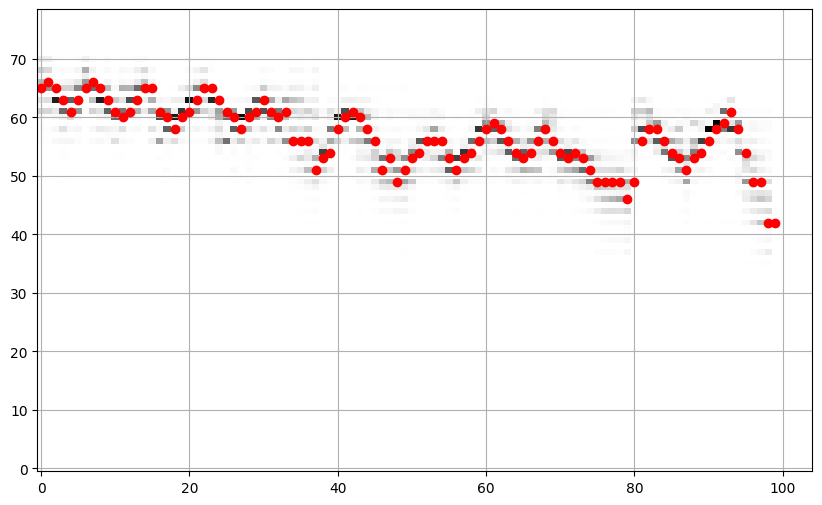

In [14]:
if False:
    prior_v = np.ones(n_x)/n_x
else:
    sum_v = np.zeros(n_x)
    for X_ohe in X_list: sum_v += np.sum(X_list[0], axis=0)
    prior_v = sum_v/np.sum(sum_v)

note_l, prediction_l = F_sample_new_sequence(model, prior_v)

print(note_l)
plt.figure(figsize=(10, 6))
plt.imshow(np.asarray(prediction_l).T, aspect='auto', origin='lower')
plt.plot(note_l, 'ro')
plt.set_cmap('gray_r')
plt.grid(True)

### Create a MIDI file and an audio file which correspond to the generated sequence

Once the new sequence has been generated (`note_l`) we transform it to a new MIDI file and perform (a very cheap) rendering of it in an audio file.

In [15]:
new_midi_data = pretty_midi.PrettyMIDI()
cello_program = pretty_midi.instrument_name_to_program('Cello')
cello = pretty_midi.Instrument(program=cello_program)
time = 0
step = 0.3
for note_number in note_l:
    myNote = pretty_midi.Note(velocity=100, pitch=note_number, start=time, end=time+step)
    cello.notes.append(myNote)
    time += step
new_midi_data.instruments.append(cello)
new_midi_data.write('output.mid')

In [16]:
%matplotlib inline
audio_data = new_midi_data.synthesize(fs=44100)
IPython.display.Audio(audio_data, rate=44100)

# Evaluation

To evaluate the work, you should rate the code for
- 1) MIDI conversion to one-hot-encoding: F_convert_midi_2_list (01)
- 2) Data conversion for the training of language model (02) `F_convert_list_2_data`
- 3) Training the language model (03)
- 4) Generating a new sequence from sampling the language model
    - `F_get_max_temperature` (04)
    - `F_sample_new_sequence` (05)

You will also rate the answer to the four questions below.

## Question 1)

FR: Que se passe-t'il si on remplace la cellule LSTM par une cellule RNNsimple ?

UK: What happens if we replace the LSTM cell by a RNNsimple cell?

**Réponse/Answer (en-dessous/below)** (1 points)

> FR: Si on utilise des cellules RNN simples à la place de LSTM, le modèle risque d'avoir du mal à apprendre et à composer de la musique. C'est parce que les cellules RNN simples ont une mémoire plus courte et oublient facilement les notes précédentes, surtout dans les morceaux longs. Les LSTM, en revanche, ont une meilleure mémoire et peuvent se souvenir des notes plus anciennes, ce qui les rend plus adaptées à la génération de musique.
>
> ---
> UK: If we use simple RNN cells instead of LSTMs, the model might struggle to learn and compose music. This is because simple RNN cells have a shorter memory and easily forget previous notes, especially in longer pieces. LSTMs, on the other hand, have a better memory and can remember older notes, making them more suitable for music generation.

## Question 2)

FR: Que se passe-t'il si l'on raccourci la longueur des séquences utilisées pour l'entrainement ? Comment palier à cet effet ?

UK: What happens if we shorten the length of the sequences used for training? How can this effect be avoided?


**Réponse/Answer (en-dessous/below)** (1 points)

> FR: Si on raccourcit les séquences d'entraînement, c'est comme si on donnait au modèle des phrases musicales plus courtes. Du coup, il risque d'avoir du mal à comprendre la structure globale des morceaux et à composer des mélodies cohérentes. Pour éviter ça, on peut essayer de rendre le modèle plus complexe en lui ajoutant des "couches" de neurones, comme si on lui donnait plus de mémoire pour se souvenir des notes.
>
> ---
> UK: If we shorten the training sequences, it's like giving the model shorter musical phrases. As a result, it may struggle to understand the overall structure of the pieces and compose coherent melodies. To avoid this, we can try to make the model more complex by adding "layers" of neurons, as if we were giving it more memory to remember notes.


## Question 3)
FR: Comment pourrait-on rendre le système `polyphonique` (plusieurs notes jouées simultanément par le même instrument) ? pour l'entrainement ? pour la génération ?

UK: How could we make the system polyphonic (several notes played simultaneously by the same instrument)? for training? for generation?


**Réponse/Answer (en-dessous/below)** (2 points)

> FR: Pour rendre le système polyphonique, il faudrait changer la façon dont le modèle représente et prédit les notes. Au lieu de prédire une seule note à la fois (avec un neurone de sortie par note possible), il devrait prédire des combinaisons de notes jouées simultanément (avec un neurone pour chaque combinaison de notes possible).
>
> Concrètement, cela implique de modifier la couche de sortie du modèle et de passer d'une représentation "une note active à la fois" à une représentation où plusieurs notes peuvent être actives en même temps. Au lieu d'avoir un neurone par touche, il faudrait par exemple un neurone pour chaque accord possible.
>
> Les données d'entraînement doivent également être modifiées pour refléter ce changement. Chaque "mot" de la séquence musicale ne représenterait plus une seule note, mais un ensemble de notes jouées simultanément.
> * Entraînement: On entraînerait le modèle avec des données contenant des exemples de plusieurs notes jouées en même temps, comme des accords.
> * Génération: Le modèle pourrait alors générer de la musique en choisissant plusieurs notes à jouer en même temps, créant ainsi des mélodies polyphoniques.
> ---
> UK: To make the system polyphonic, we would need to change how the model represents and predicts notes. Instead of predicting a single note at a time (with one output neuron per possible note), it should predict combinations of notes played simultaneously (with one neuron for each possible combination of notes).
>
> Concretely, this means modifying the output layer of the model and moving from a representation of "one active note at a time" to a representation where multiple notes can be active simultaneously. For example, instead of having one neuron per key, we would need a neuron for each possible chord.
>
> The training data must also be modified to reflect this change. Each "word" of the musical sequence would no longer represent a single note, but a set of notes played simultaneously.
> * Training: We would train the model with data containing examples of multiple notes played at the same time, like chords.
> * Generation: The model could then generate music by choosing multiple notes to play at the same time, creating polyphonic melodies.


